In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import json
from jsonschema import validate, ValidationError

schema = {
    '$id' : 'Personal schema',
    '$schema': 'https://json-schema.org/draft/2020-12/schema',
    'title': 'Schema for image analysis of sintered tungsten samples',

    "Mechanical Properties": {
        "Stress": {
            "type": "integer",
            "unit": "MPa",
            "description": "Stress values calculated from load data, units are MPa"
        },
        "Strain": {
            "type": "integer",
            "unit": "Unitless",
            "description": "Strain values obtained from DIC machine, unitless"
        },
    },
    "Image analysis results": {
        "Particle area": {
            "type": "integer",
            "unit": "Micrometer squared",
            "description": "Particle area obtained from image analysis values in um squared, represented in histogram"
        },
        "Intergranular phase area":{
            "type": "integer",
            "unit": "Micrometer squared",
            "description": "Intergranular phase area from image analysis, units in um squared, again represented in a histogram"
        },
    },
}


# Loading the psylotech and DIC data then graphing

In [2]:
#First thing first load the data!
data_path = r"C:\Users\jmgwh\Desktop\MASE_6401\Project" #Make sure this is the folder where your data is!
data_files = glob.glob(data_path + "\*.txt")


load_data = pd.read_csv(data_files[0], sep='\t', header=13)
load_data.head() #If you see colums with: Time, Encoder displacement, etc SUCCESS!


,Time (s),Encoder Displacement (m),Load Cell Full Scale (N),Load Cell Window (N),Load Cell Temperature (C),Load Cell Gradient (C),Inlet Temperature (C),Outlet Temperature (C),Specimen Temperature (C),Primary Current (amp),Trigger,Segment No.
0,0.0,1.519918e-09,0.098385,NaN,31.941959,0.444126,19.948175,21.792580,20.870377,-0.078,0.0,0.0
1,0.1,-2.239645e-08,0.245216,NaN,31.941971,0.444022,19.942075,21.780967,20.861521,-0.102,1.0,0.0
2,0.2,-6.255507e-07,0.197223,NaN,31.942170,0.444309,19.950979,21.784264,20.867622,-0.240,2.0,0.0
3,0.3,-8.366108e-07,0.094644,NaN,31.941464,0.444131,19.947741,21.781543,20.864642,-0.222,3.0,0.0
4,0.4,-1.164108e-06,-0.013211,NaN,31.942249,0.444050,19.951723,21.786216,20.868969,-0.228,4.0,0.0


In [3]:
#Specimen geometry mannually input for now units are mm
width_mm = 1
thickness_mm = 0.5
gauge_length = 4

area_ten = width_mm * thickness_mm

schema['Mechanical Properties']['Specimen geometry'] = { "Width" : width_mm,
                                                         "Thickness": thickness_mm,
                                                         "Gauge length": gauge_length,
                                                         "Units": "mm",
                                                         "Description": "Tensile sample measurements in mm"
                                                       }
                                                         

In [4]:
#Stress calculation
load_data['Stress (MPa)'] = -load_data['Load Cell Full Scale (N)']/area_ten
schema['Mechanical Properties']['Stress']['Values'] = { "Calculated values": load_data['Stress (MPa)'].tolist(),
                                                        "Description": "Calculated values by dividing load data vs area"}
load_data['Stress (MPa)'].head()


0   -0.196770
1   -0.490432
2   -0.394445
3   -0.189289
4    0.026421
Name: Stress (MPa), dtype: float64

In [5]:
dic_files = glob.glob(data_path + "\*.csv")

dic_data = pd.read_csv(dic_files[0], header = 1)
dic_data.head()

,Index [1],exx [1] - Lagrange,eyy [1] - Lagrange
0,0,-5.241660e-17,-4.107700e-17
1,1,-1.301090e-04,-1.888920e-04
2,2,-6.570430e-05,-1.069880e-04
3,3,-2.468980e-04,-4.371670e-04
4,4,-2.326000e-04,-3.655580e-04


In [6]:
#Renaming the strain from DIC (eyy Lagrange) to Strain for simplicity
load_data['Strain'] = -dic_data['eyy [1] - Lagrange'] / gauge_length
load_data['Strain (%)'] = load_data['Strain']*100
schema['Mechanical Properties']['Strain']['Values'] = { "Calculated values": load_data['Strain'].tolist(),
                                                        'Description': "Strain values calculated from strain values obtained from DIC"
                                                      }



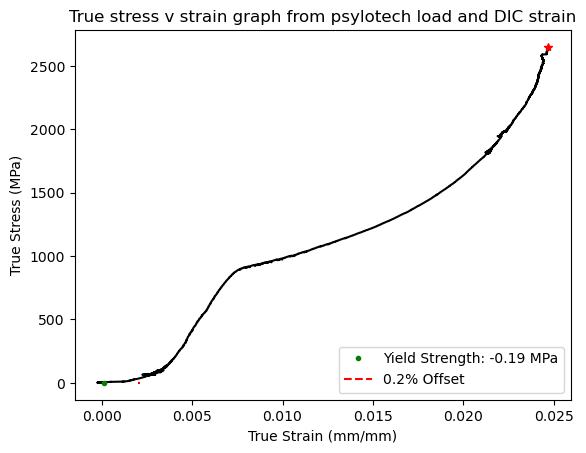

In [7]:
#linear regression function, it will be overused in the following sections
def linear_reg(x, y):	
    x1 = x
    y1 = y
    Ex = np.sum(x1)
    Ey = np.sum(y1)
    x2 = x1**2
    y2 = y1**2
    Ex2 = np.sum(x2)
    Ey2 = np.sum(y2)
    xy = x1*y1
    Exy = np.sum(xy)
    n = len(x1)
    m = ((n*Exy) - (Ex*Ey))/((n*Ex2) - (Ex**2))
    b = (Ey - (m*Ex))/n
    a = np.sqrt((n*Ex2)-(Ex**2))
    a2 = np.sqrt((n*Ey2)-(Ey**2))
    r = ((n*Exy)-(Ex*Ey))/((a)*(a2))

    return m, b, r

slices = np.linspace(0, len(load_data['Strain']-1), 100, dtype = int)

slices_cut = []

for i in range(len(slices)-1):
    start = slices[i]
    stop = slices[i+1]
    x = load_data['Strain'][start:stop]
    y = load_data['Stress (MPa)'][start:stop]
    m, b, r = linear_reg(x,y)
    slices_cut.append(m)
    if m < 0:
        cutoff = start


load_data['Stress 2 (MPa)'] = load_data['Stress (MPa)'][:cutoff]
load_data['Strain 2'] = load_data['Strain'][:cutoff]
load_data['True Stress (MPa)'] = load_data['Stress 2 (MPa)'] * (1+load_data['Strain 2'])
load_data['True Strain'] = np.log(1+load_data['Strain 2'])
                                                                
slc = np.linspace(0, len(load_data['True Strain']-1), 10, dtype=int)

slp = []
inter = []
error = []

for a in range(len(slc)-1):
    start = slc[a]
    stop = slc[a+1]
    x = load_data['True Stress (MPa)'][start:stop]
    y = load_data['True Strain'][start:stop]
    m, b, r = linear_reg(x,y)
    y2 = (((load_data['True Stress (MPa)'])*m)+b)
    slp.append(m)
    inter.append(b)
    error.append(r)

bestm = np.max(slp)
bestint = inter[np.where(slp == bestm)[0][0]]


slopes = np.array(slp)
yoff = (bestm)*(load_data['True Strain']-0.002)
xoff = load_data['True Strain'] + 0.002

truoffy = bestm*load_data['True Strain']

diff = load_data['True Stress (MPa)'] - yoff

ys_idx = np.argwhere(np.diff(np.sign(diff)))[0][0]

offsetx = load_data['True Strain'][ys_idx]
offsety = load_data['True Stress (MPa)'][ys_idx]


UTS = load_data['True Stress (MPa)'].where(load_data['True Stress (MPa)'] == np.max(load_data['True Stress (MPa)']))

UTSx = load_data['True Strain'].where(load_data['True Stress (MPa)'] == UTS)


plt.plot(load_data['True Strain'], load_data['True Stress (MPa)'], 'black')
plt.plot(offsetx, offsety, 'g.', label = f'Yield Strength: {offsety:.2f} MPa')
plt.plot(UTSx, UTS, 'r*')
plt.plot(xoff[:ys_idx], truoffy[:ys_idx], '--', color='red', label = '0.2% Offset')
plt.xlabel('True Strain (mm/mm)')
plt.ylabel('True Stress (MPa)')
plt.title('True stress v strain graph from psylotech load and DIC strain')
plt.legend(loc = 'lower right')

plt.savefig('Stress v strain graph.png')
plt.show()

schema['Mechanical Properties']['UTS'] = { "Value" : "UTS",
                                           "Description" : "Ultimate tensile strength, found by the highsest stress value",
                                           "Units": "MPa"
                                         }
schema['Mechanical Properties']['Yield Strength'] = { "Value" : offsety,
                                                      "Description": "Yield strength, calculated using the linear regression function developed in class",
                                                      "Units": "MPa"
                                                    }



# Now lets take a look at the microstructures

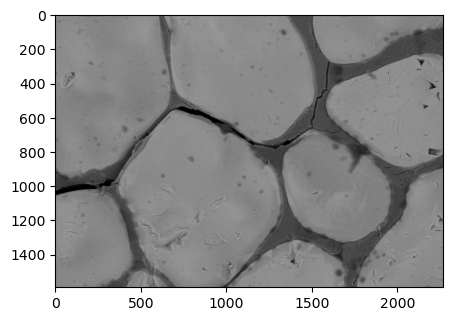

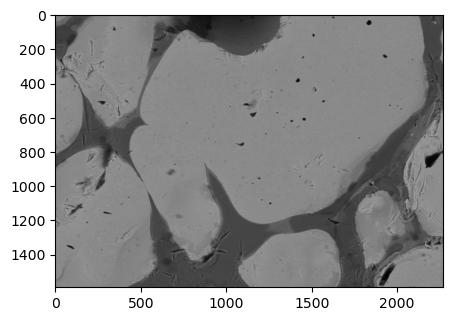

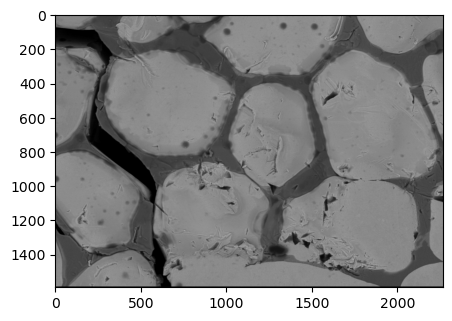

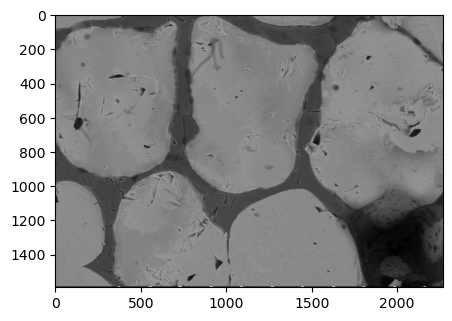

In [8]:
#From the class makes it seamless to show the images
def show_img(image):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(image, cmap = 'gray')
    plt.show()
    plt.close(fig)


#PLace images in folder then copy that folder's path here
image_path = r"C:\Users\jmgwh\Desktop\MASE_6401\Project\Fake_slices"

path = glob.glob(image_path + "\*.tif") #In this case the files are .tif, change it to fit your image files

for image in path:

    image = cv2.imread(image)
    show_img(image)


#Every image is completely different, values will be obtained from Fiji/ImageJ etc
scale_bar = 100 #What is the value of the scale bar (um by default)
distance_in_pixels = 1014
px2um = (scale_bar/distance_in_pixels)

schema['Scale'] = { "Description": "Since we are using pictures with scale bars the conversion from pixels to um has to be set manually",
                    "Distance in pixels" : distance_in_pixels,
                    "Scale bar value (um)": scale_bar
                  }


# Modyfing images for image analysis

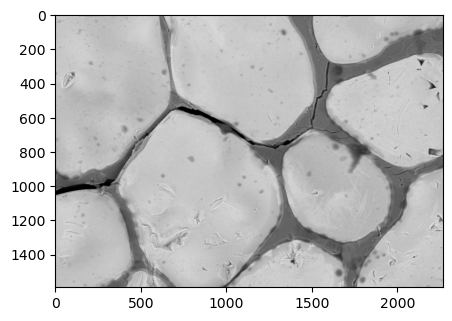

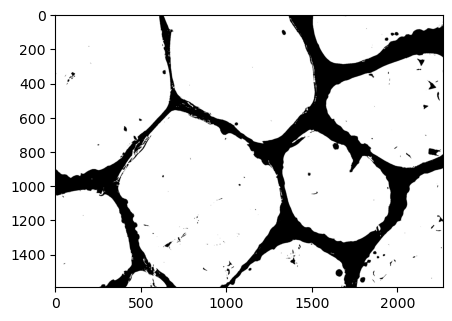

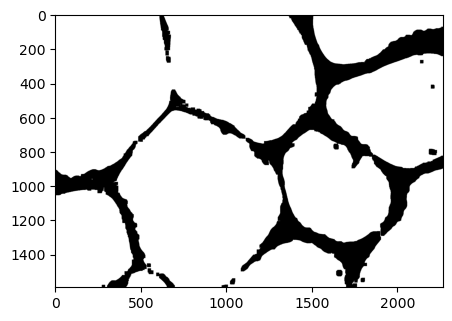

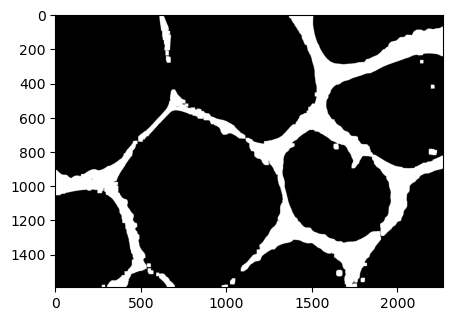

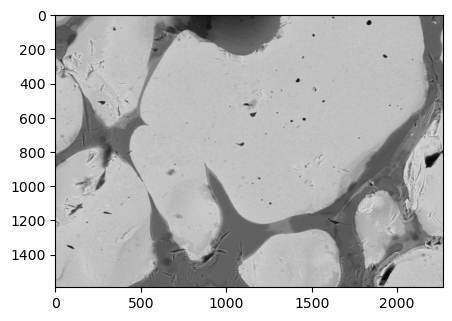

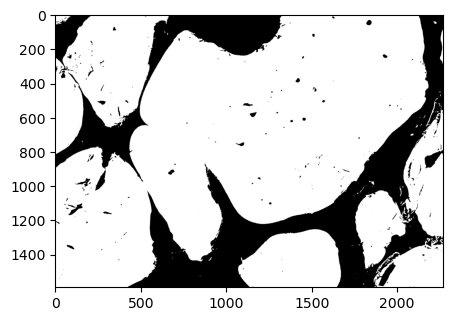

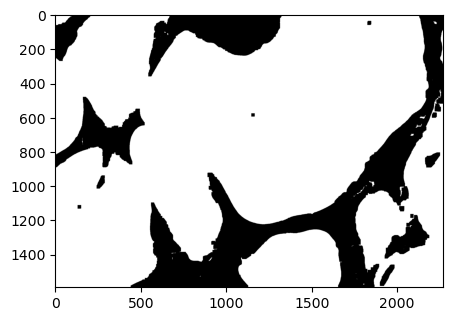

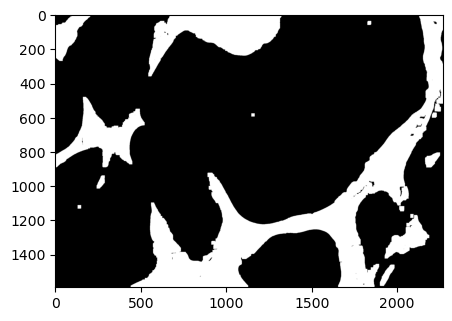

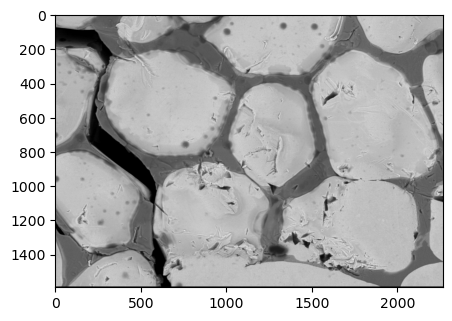

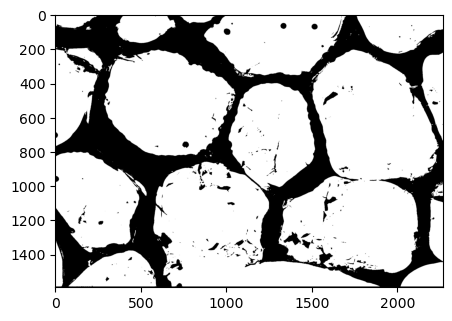

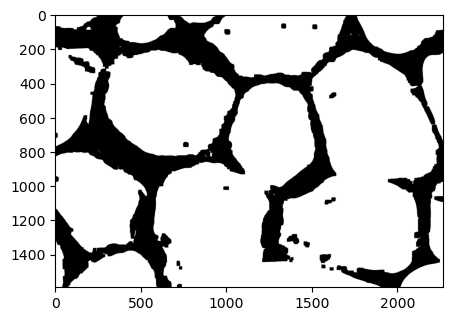

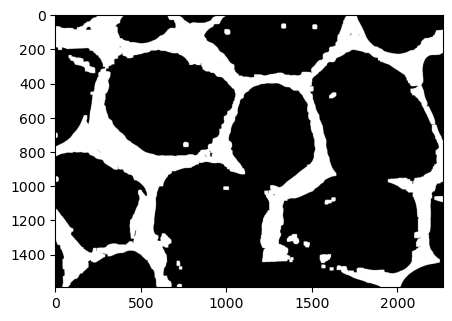

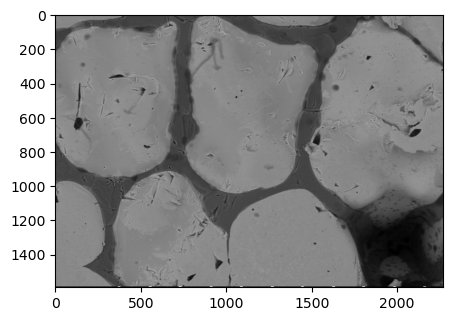

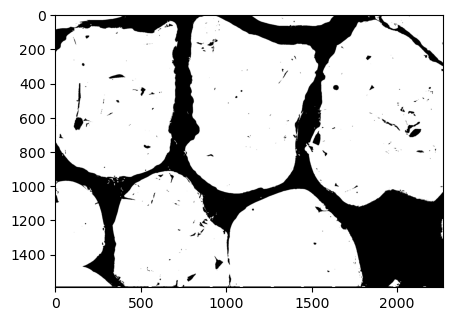

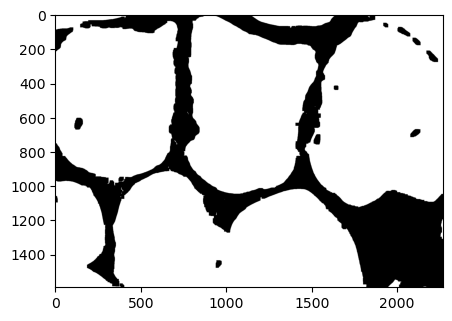

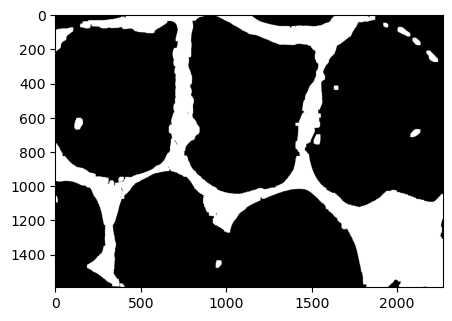

In [9]:
particle_masks = []
phase_masks = []
for image in path:

    image = cv2.imread(image)
    

    #Make image grayscale 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    #Making sure these reset for each image to avoid errors
    particle_mask = None
    phase_mask = None


    show_img(gray)
    #From gray scale to binary
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    particle_mask = binary
   
    #Morphological closes to try to clean up images
    
    kernel1 = np.ones((3,3), np.uint8) #Exprimentally obtained kernel size
    kernel2 = np.ones((5,5), np.uint8)
    kernel3 = np.ones((10,10), np.uint8)
    particle_mask = cv2.dilate(particle_mask, kernel1, iterations = 4)
    particle_mask = cv2.morphologyEx(particle_mask, cv2.MORPH_CLOSE, kernel3)
    particle_mask = cv2.erode(particle_mask, kernel2, iterations = 2)
    
    
    phase_mask = cv2.bitwise_not(particle_mask)
    
    
    particle_masks.append(particle_mask)
    phase_masks.append(phase_mask)
    
    show_img(binary)
    show_img(particle_mask)
    show_img(phase_mask)



# Measuring the area of the primary phase (Tungsten) 

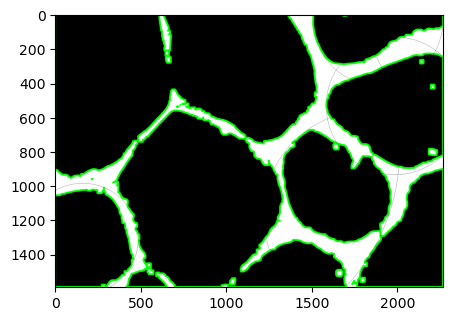

The average grain size is: 30.59778307201311


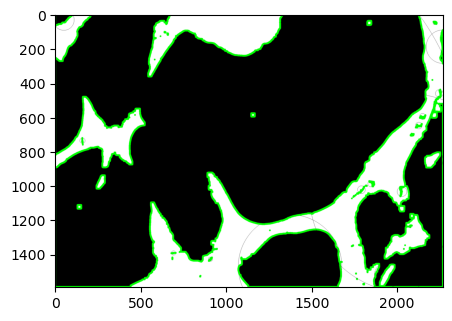

The average grain size is: 17.72430196220554


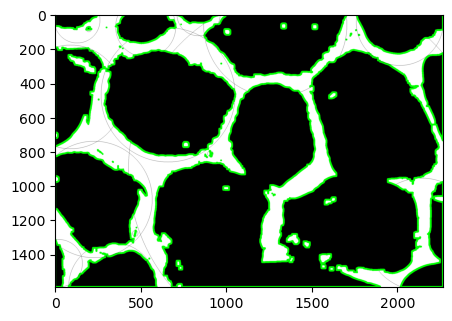

The average grain size is: 16.3066933606742


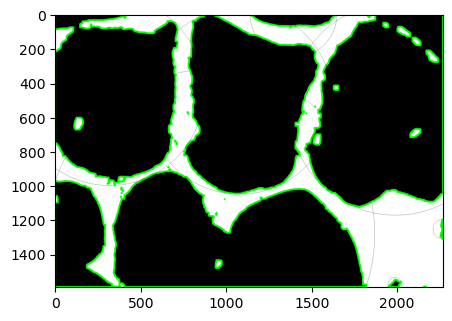

The average grain size is: 17.33396103592311
[[[134 134 134]
  [134 134 134]
  [133 133 133]
  ...
  [134 134 134]
  [133 133 133]
  [132 132 132]]

 [[135 135 135]
  [136 136 136]
  [135 135 135]
  ...
  [132 132 132]
  [131 131 131]
  [130 130 130]]

 [[135 135 135]
  [135 135 135]
  [134 134 134]
  ...
  [138 138 138]
  [135 135 135]
  [133 133 133]]

 ...

 [[ 17  17  17]
  [ 17  17  17]
  [ 18  18  18]
  ...
  [ 10  10  10]
  [ 10  10  10]
  [ 11  11  11]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


In [21]:
#Measuring particles
pixel_cnt = []
particle_size = []
equivalent_diameter = []
tungsten_areas = []
for particles in particle_masks:
    #Using a separate contour here to reduce noise even further, with external as far as I recall from google searches only uses the external contours ignoring those ugly holes
    contour_part, p = cv2.findContours(particles, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    colored_pmask = cv2.cvtColor(particles, cv2.COLOR_GRAY2BGR)
    colored_pmask = cv2.bitwise_not(colored_pmask)

    px = cv2.countNonZero(particles)
    pixel_cnt.append(px)
    #Similar to what we did in class but since I have no use for circularity found some very similar but simpler ways to achieve the same results
    for cont in contour_part:
        area = cv2.contourArea(cont)
        particle_size.append(area)
    
        
        
        (cx, cy), r = cv2.minEnclosingCircle(cont)
    
        center = (int(cx), int(cy))
        radius = int(r)
        conts = cv2.circle(colored_pmask, center, radius, (0, 0, 0), 0)
        
        diameter = r*2
        equivalent_diameter.append(diameter)
        cv2.drawContours(colored_pmask, [cont], -1, (0,255,0), 10)
    show_img(conts)
    diam = np.array(equivalent_diameter)
    diameter_um = diam*px2um
    print(f"The average grain size is: {np.mean(diameter_um)}")
    
    tungsten_area = np.sum(particle_size) #This is in pixels!
  
    tungsten_areas.append(tungsten_area)


# Particle area measurements neatly shown in a histogram

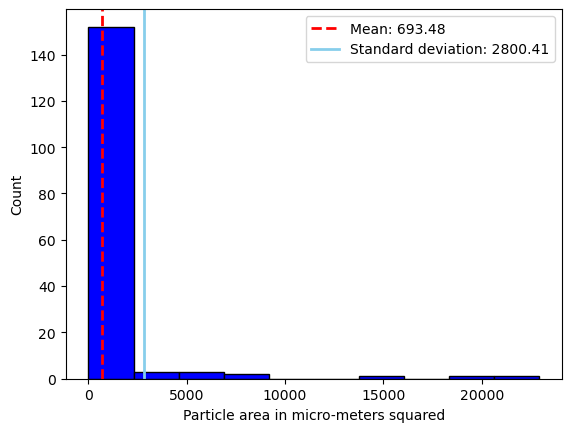

In [18]:
particle_size = np.array(particle_size)*px2um
mean_part = np.mean(particle_size)
std_part = np.std(particle_size)

plt.hist(particle_size, color = 'blue', edgecolor = 'black')
plt.axvline(mean_part, color = 'red', linestyle = 'dashed', linewidth =2, label = f'Mean: {mean_part:.2f}')
plt.axvline(std_part, color = 'skyblue', linewidth = 2, label = f'Standard deviation: {std_part:.2f}')
plt.legend()
plt.xlabel('Particle area in micro-meters squared')
plt.ylabel('Count')
plt.savefig('Particle area.png')
plt.show()

schema['Image analysis results']['Particle area']['Values'] = { "Particle areas": particle_size.tolist(),
                                                                "Mean particle area": mean_part,
                                                                "Standard deviatoin": std_part,
                                                                "Description": "The area of the large grains, in um squared",
                                                                "Units": "Micrometers ^2"
                                                              }


# Measureing the intergranular phase (Nickel) using fit ellipse

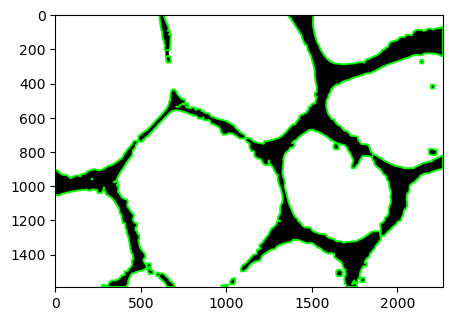

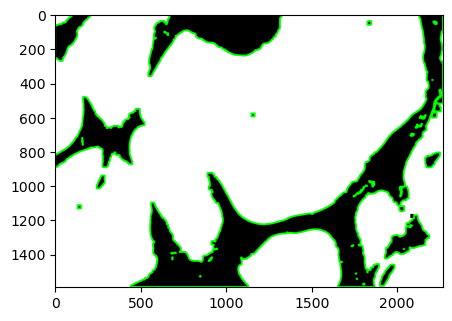

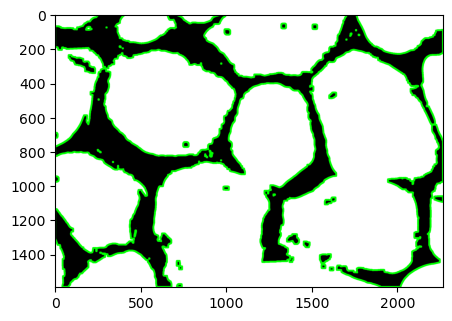

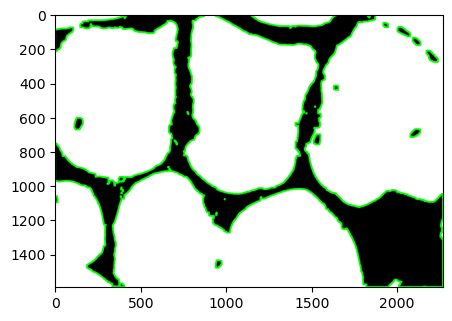

In [12]:
phase_area = []
nickel_areas = []
aspect_ratio = []
for nickels in phase_masks:
    contour_phase, k = cv2.findContours(nickels, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    colored_phmask = cv2.cvtColor(nickels, cv2.COLOR_GRAY2BGR)
    colored_phmask = cv2.bitwise_not(colored_phmask)
    
    for cont in contour_phase:
        area = cv2.contourArea(cont)
        
     
        if len(cont) < 5:
            continue
        ellipses  = cv2.fitEllipse(cont)
        (Cx, Cy), (Maxis, maxis), angle = ellipses
        Maxis_um = Maxis*(100/px2um)
        maxis_um = maxis*(100/px2um)
        aspect = Maxis_um/maxis_um
        aspect_ratio.append(aspect)
        ellipsis_area = np.pi * (Maxis_um/2) * (maxis_um/2)
        phase_area.append(ellipsis_area)
        cv2.drawContours(colored_phmask, [cont], -1, (0,255,0), 10)
    
    show_img(colored_phmask)
    nickel_area = np.sum(phase_area)
    
    nickel_areas.append(nickel_area)

# Histogram of the nickel phase areas

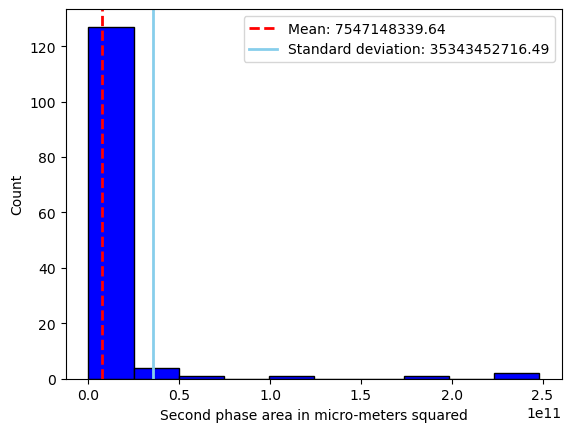

In [13]:
phase_area = np.array(phase_area)*px2um
mean_phasearea = np.mean(phase_area)
std_phasearea = np.std(phase_area)

plt.hist(phase_area, color = 'blue', edgecolor = 'black')
plt.axvline(mean_phasearea, color = 'red', linestyle = 'dashed', linewidth =2, label = f'Mean: {mean_phasearea:.2f}')
plt.axvline(std_phasearea, color = 'skyblue', linewidth = 2, label = f'Standard deviation: {std_phasearea:.2f}')
plt.legend()
plt.xlabel('Second phase area in micro-meters squared')
plt.ylabel('Count')
plt.savefig('Second phase.png')
plt.show()

schema['Image analysis results']['Intergranular phase area']['Values'] = { "Intergranular areas": phase_area.tolist(),
                                                                           "Mean area": mean_phasearea,
                                                                           "Standard deviation": std_phasearea,
                                                                           "Description": "Intergranular phase areas also in micrometers squared",
                                                                           "Units": "Micrometer ^2"
                                                                         }


In [17]:

with open('project_test.json', 'w') as outfile:
    json.dump(schema, outfile, sort_keys=False, indent=4)

In [15]:
#json validation

try:
    with open('schema.json', 'r') as infile1:
        json.load(infile1)
except FileNotFoundError:
    print("You sure that exists?")
    

    with open('schema2.json', 'r') as infile2:
        json.load(infile2)
except FileNotFoundError:
    print("You sure that exists?")
    
    
    validate(instance=infile2, schema=infile1)
    print("Looks good!")
except ValidationError:
    print("Validation error:(")